# Titanic Space
https://www.kaggle.com/competitions/spaceship-titanic/overview/description

## Data description
- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, 
- FoodCourt, 
- ShoppingMall, 
- Spa, 
- VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# Content
* [Import necessary libraries](#imports)
* [Load source data](#load_data)
* [EDA](#eda)
* [Model](#model)

## Import necessary libraries<a class="anchor" id="imports"></a>

In [1]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier

## Load source data<a class="anchor" id="load_data"></a>

In [2]:
test = pd.read_csv("Data/test.csv")
train = pd.read_csv("Data/train.csv")

In [3]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [4]:
train_X, train_y = train[train.columns[:-1]], train[train.columns[-1]]

### Number of nulls

In [5]:
# Number of nulls
pd.DataFrame(train_X.isnull().sum(), columns = ['missing_count']).assign(missing_pct = lambda x: x['missing_count']/train_X.shape[0]*100)

,missing_count,missing_pct
PassengerId,0,0.000000
HomePlanet,201,2.312205
CryoSleep,217,2.496261
Cabin,199,2.289198
Destination,182,2.093639
Age,179,2.059128
VIP,203,2.335212
RoomService,181,2.082135
FoodCourt,183,2.105142
ShoppingMall,208,2.392730


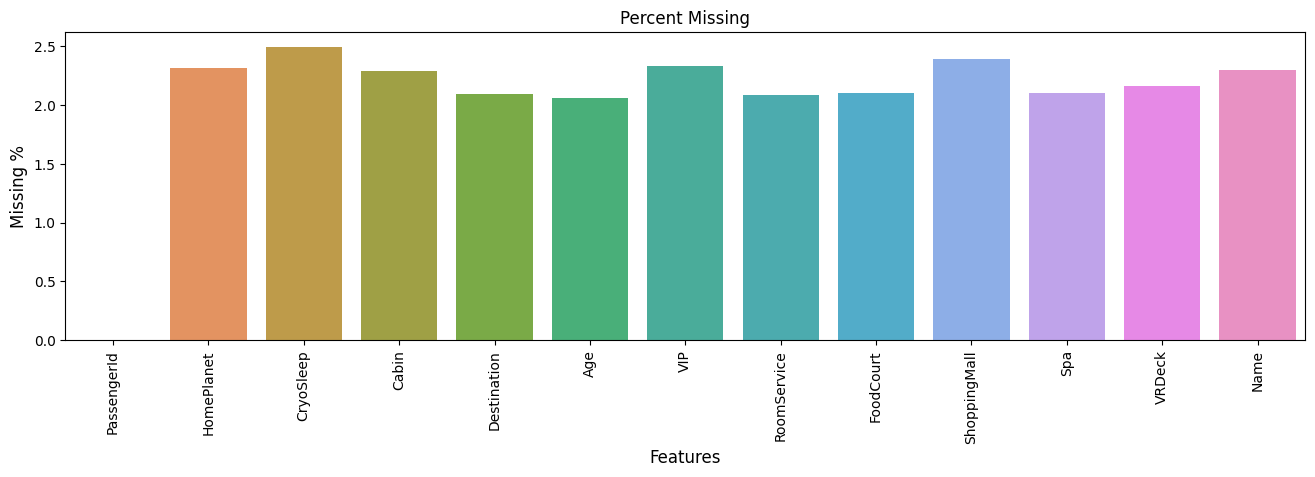

In [6]:
nan_train_X = ((train_X.isna().sum() / train_X.shape[0]*100)).reset_index()
nan_train_X.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(x=nan_train_X['feature'], y=nan_train_X['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing %', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

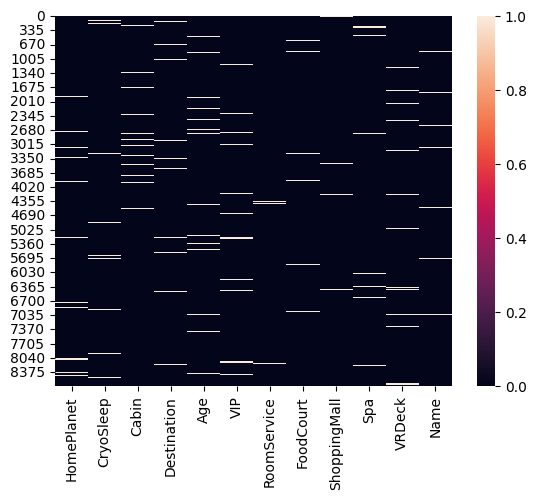

In [7]:
sns.heatmap(train_X[train_X.columns[1:]].isnull())
plt.show()

## EDA<a class="anchor" id="eda"></a>

In [8]:
# TODO: For filling nan create model for each of features


In [9]:
train_X.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


### PassangerID

In [10]:
#Find Group and No Pass
train_X[["G_Passenger", 'N_Passenger']] = train_X["PassengerId"].str.split('_', expand=True).astype('int')
test[["G_Passenger", 'N_Passenger']] = test["PassengerId"].str.split('_', expand=True).astype('int')

#Set the Index
train_X.set_index('PassengerId',inplace=True)
test.set_index('PassengerId', inplace=True)


train_X.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,G_Passenger,N_Passenger
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,1,1
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,2,1
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,3,1
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,3,2
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,4,1


### Cabin

In [11]:
# Fill nan special values and split the field for three different fields

imp = SimpleImputer(strategy='constant', fill_value='X/9999/X')

train_X['Cabin']=imp.fit_transform(train_X[['Cabin']])
test['Cabin'] = imp.fit_transform(test[['Cabin']])

train_X.loc[:,['Cabin_1']] = train_X.Cabin.str.split("/",expand=True).iloc[:,0]
train_X.loc[:,['Cabin_2']] = train_X.Cabin.str.split("/",expand=True).iloc[:,1]
train_X.loc[:,['Cabin_3']] = train_X.Cabin.str.split("/",expand=True).iloc[:,2]

test.loc[:,['Cabin_1']] = test.Cabin.str.split("/",expand=True).iloc[:,0]
test.loc[:,['Cabin_2']] = test.Cabin.str.split("/",expand=True).iloc[:,1]
test.loc[:,['Cabin_3']] = test.Cabin.str.split("/",expand=True).iloc[:,2]

train_X.drop(['Cabin'], axis=1, inplace=True)
test.drop(['Cabin'], axis=1, inplace=True)

### Destination

In [12]:
imp = SimpleImputer(strategy='constant', fill_value='Unknown')

train_X['Destination']=imp.fit_transform(train_X[['Destination']])
test['Destination']=imp.fit_transform(test[['Destination']])

### HomePlanet

In [13]:
imp = SimpleImputer(strategy="most_frequent")

train_X['HomePlanet']=imp.fit_transform(train_X[['HomePlanet']])
test['HomePlanet']=imp.fit_transform(test[['HomePlanet']])

### CryoSleep

In [14]:
imp = SimpleImputer(strategy="most_frequent")

train_X['CryoSleep']=imp.fit_transform(train_X[['CryoSleep']])
test['CryoSleep']=imp.fit_transform(test[['CryoSleep']])

### VIP

In [15]:
imp = SimpleImputer(strategy="most_frequent")

train_X['VIP']=imp.fit_transform(train_X[['VIP']])
test['VIP']=imp.fit_transform(test[['VIP']])

### Age

In [16]:
imp = SimpleImputer(strategy="median")

train_X['Age']=imp.fit_transform(train_X[['Age']])
test['Age']=imp.fit_transform(test[['Age']])

### RoomService

In [17]:
#Fill Na with 0
imp = SimpleImputer(strategy='constant', fill_value=0)
train_X['RoomService']=imp.fit_transform(train_X[['RoomService']])
test['RoomService']=imp.fit_transform(test[['RoomService']])

### FoodCourt

In [18]:
imp = SimpleImputer(strategy='constant', fill_value=0)
train_X['FoodCourt']=imp.fit_transform(train_X[['FoodCourt']])
test['FoodCourt']=imp.fit_transform(test[['FoodCourt']])

### ShoppingMall

In [19]:
imp = SimpleImputer(strategy='constant', fill_value=0)
train_X['ShoppingMall']=imp.fit_transform(train_X[['ShoppingMall']])
test['ShoppingMall']=imp.fit_transform(test[['ShoppingMall']])

### Spa

In [20]:
imp = SimpleImputer(strategy='constant', fill_value=0)
train_X['Spa']=imp.fit_transform(train_X[['Spa']])
test['Spa']=imp.fit_transform(test[['Spa']])

### VRDeck

In [21]:
imp = SimpleImputer(strategy='constant', fill_value=0)
train_X['VRDeck']=imp.fit_transform(train_X[['VRDeck']])
test['VRDeck']=imp.fit_transform(test[['VRDeck']])

### Name

In [22]:
train_X.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

### Result EDA

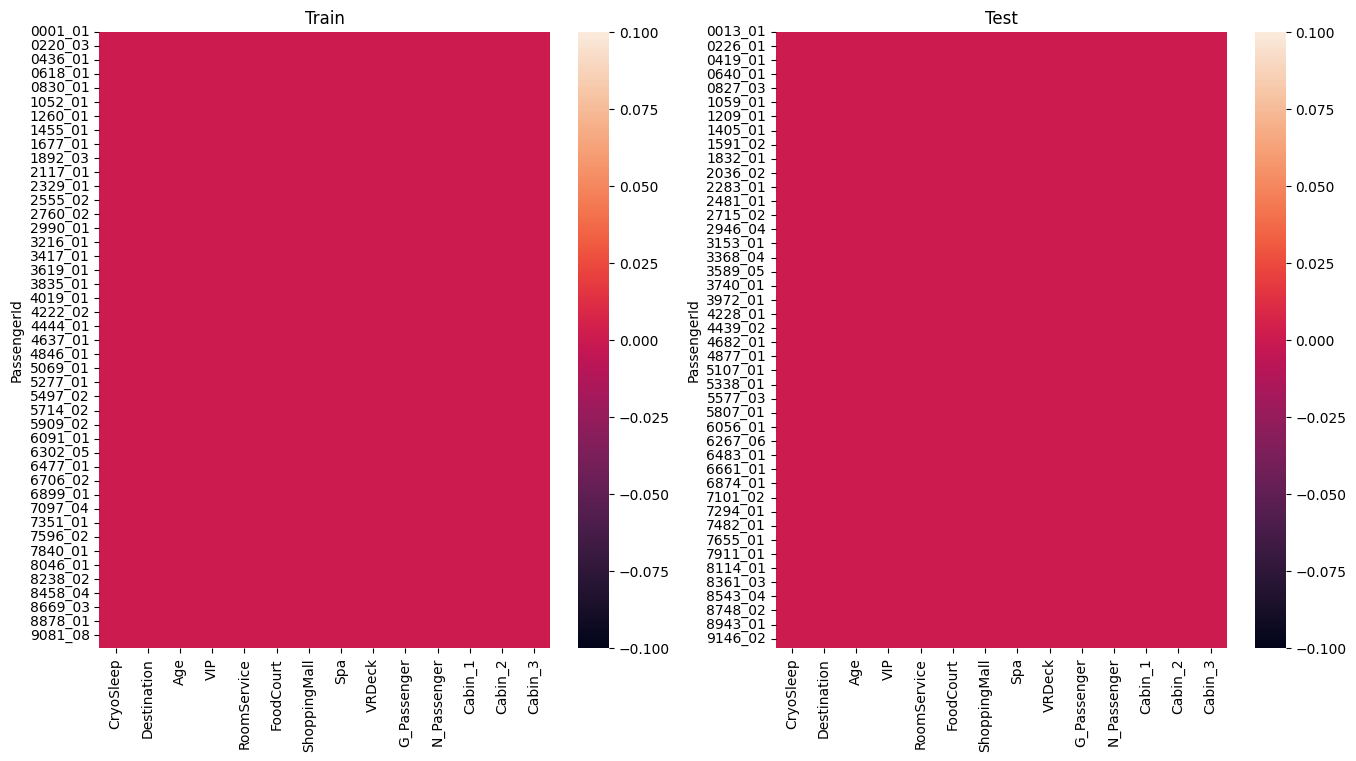

In [23]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.heatmap(train_X[train_X.columns[1:]].isnull())
ax.title.set_text('Train')

ax = fig.add_subplot(1, 2, 2)
ax = sns.heatmap(test[test.columns[1:]].isnull())
ax.title.set_text('Test')

plt.show()

### Feature engineering

In [24]:
#Total Spend 
train_X['total_spent']= train_X['RoomService']+ train_X['FoodCourt']+ train_X['ShoppingMall']+ train_X['Spa']+ train_X['VRDeck']

In [25]:
#Age Group Pass
train_X['AgeGroup'] = pd.cut(train_X.Age,bins=[0, 5, 12, 18, 50, 150], labels=['Baby','Child','Teen', 'Adult','Elderly'])
#Fill Value of NA
imp = SimpleImputer(strategy='constant', fill_value='Baby')
train_X['AgeGroup']=imp.fit_transform(train_X[['AgeGroup']])

In [26]:
categorical_cols= ['HomePlanet','CryoSleep','Destination','VIP','Cabin_1','Cabin_3','Cabin_2','AgeGroup']
for i in categorical_cols:
    print(i)
    le=LabelEncoder()
    arr=np.concatenate([train_X[i]], axis=0).astype(str)
    le.fit(arr)
    train_X[i]=le.transform(train_X[i].astype(str))

HomePlanet
CryoSleep
Destination
VIP
Cabin_1
Cabin_3
Cabin_2
AgeGroup


## Model<a class="anchor" id="model"></a>

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    train_X, train_y, test_size=0.2, random_state=13
)

In [28]:
model=CatBoostClassifier(iterations=3000,
                         eval_metric='Accuracy',
                        verbose=0)

In [29]:
model.fit(X_train,y_train)

In [30]:
pred=model.predict(X_test)

In [31]:
pred[:5].astype('bool')

array([ True,  True,  True,  True,  True])

In [32]:
y_test.values[:5]

array([ True,  True,  True,  True,  True])

In [33]:

print(accuracy_score(y_test.values,pred.astype('bool')))

0.49396204715353653
